In [1]:
!git clone https://github.com/sakanaowo/PlantXViT

Cloning into 'PlantXViT'...
remote: Enumerating objects: 50396, done.
remote: Counting objects: 100% (125/125), done.
remote: Compressing objects: 100% (90/90), done.
remote: Total 50396 (delta 52), reused 93 (delta 22), pack-reused 50271 (from 1)
Receiving objects: 100% (50396/50396), 1.66 GiB | 43.19 MiB/s, done.
Resolving deltas: 100% (30437/30437), done.
Updating files: 100% (50041/50041), done.


In [2]:
%cd PlantXViT

/kaggle/working/PlantXViT


In [19]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import requests
from io import BytesIO
import os
import matplotlib.pyplot as plt

# Optional: IPython display for notebook
from IPython.display import display

# Preprocessing giống khi train
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Danh sách nhãn Apple dataset
apple_labels = ['healthy', 'multiple_diseases', 'rust', 'scab']

def predict_image(image_path_or_url, model, class_names=apple_labels, device='cuda'):
    model.eval()
    model.to(device)

    # Load ảnh
    try:
        if image_path_or_url.startswith("http"):
            response = requests.get(image_path_or_url)
            image = Image.open(BytesIO(response.content)).convert("RGB")
            source = "URL"
        else:
            image = Image.open(image_path_or_url).convert("RGB")
            source = "Local"
    except Exception as e:
        print(f"Failed to load image: {e}")
        return None

    # Hiển thị ảnh gốc
    plt.imshow(image)
    plt.axis('off')
    plt.title("From " + source)
    plt.show()

    # Tiền xử lý
    input_tensor = preprocess(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        probs = F.softmax(output, dim=1)
        top_prob, pred_class = torch.max(probs, dim=1)

    label = class_names[pred_class.item()]
    confidence = top_prob.item()

    print(f"Predicted: {label} ({confidence * 100:.2f}%)")
    return {
        'label': label,
        'confidence': confidence,
        'probabilities': probs.cpu().numpy()[0]
    }


In [6]:
import torch
import torch.nn as nn
import torchvision.models as models


# inception blockall 4 variations
class InceptionBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.branch1x1 = nn.Conv2d(in_channels, 128, kernel_size=1)

        self.branch3x3 = nn.Sequential(
            nn.Conv2d(in_channels, 128, kernel_size=(1, 3), padding=(0, 1)),
            nn.Conv2d(128, 128, kernel_size=(3, 1), padding=(1, 0)),
        )

        self.branch_pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, 128, kernel_size=1),
        )

    def forward(self, x):
        b1 = self.branch1x1(x)
        b2 = self.branch3x3(x)
        b3 = self.branch_pool(x)
        return torch.cat([b1, b2, b3], dim=1)


# patch embedding: split patch -> Linear
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels, patch_size=5, emb_size=16):
        super().__init__()
        self.patch_size = patch_size
        self.emb_size = emb_size
        self.proj = nn.Linear(in_channels * patch_size * patch_size, emb_size)

    def forward(self, x):
        B, C, H, W = x.shape
        x = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        x = x.permute(0, 2, 3, 1, 4, 5).contiguous()
        x = x.view(B, -1, C * self.patch_size * self.patch_size)
        return self.proj(x)  # shape: (b,num patches,emb size)


# -------- Transformer Encoder Block (ViT block) --------
class TransformerBlock(nn.Module):
    def __init__(self, emb_size=16, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(emb_size)
        self.attn = nn.MultiheadAttention(emb_size, num_heads=2, batch_first=True)
        self.norm2 = nn.LayerNorm(emb_size)
        self.mlp = nn.Sequential(
            nn.Linear(emb_size, emb_size * 2),
            nn.GELU(),
            nn.Linear(emb_size * 2, emb_size),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        x_attn, _ = self.attn(self.norm1(x), self.norm1(x), self.norm1(x))
        x = x + x_attn
        x = x + self.mlp(self.norm2(x))
        return x


# -------- PlantXViT Model --------
class PlantXViT(nn.Module):
    def __init__(self, num_classes=4, patch_size=5, emb_size=16, num_blocks=4, dropout=0.1):
        super().__init__()

        # VGG16 (2 blocks)
        vgg = models.vgg16(pretrained=True).features
        self.vgg_block = nn.Sequential(*vgg[:10])  # output: (B, 128, 56, 56)

        # Inception-like block → (B, 384, 56, 56)
        self.inception = InceptionBlock(in_channels=128)

        # Patch Embedding → (B, 121, 16)
        self.patch_embed = PatchEmbedding(in_channels=384, patch_size=patch_size, emb_size=emb_size)

        # Transformer blocks
        self.transformer = nn.Sequential(*[TransformerBlock(emb_size, dropout) for _ in range(num_blocks)])

        # Classification head
        self.norm = nn.LayerNorm(emb_size)
        self.global_pool = nn.AdaptiveAvgPool1d(1)  # (B, emb_size, 1)
        self.classifier = nn.Linear(emb_size, num_classes)

    def forward(self, x):
        x = self.vgg_block(x)  # (B, 128, 56, 56)
        x = self.inception(x)  # (B, 384, 56, 56)
        x = self.patch_embed(x)  # (B, 121, 16)
        x = self.transformer(x)  # (B, 121, 16)
        x = self.norm(x)  # (B, 121, 16)
        x = x.permute(0, 2, 1)  # (B, 16, 121)
        x = self.global_pool(x).squeeze(-1)  # (B, 16)
        return self.classifier(x)  # (B, num_classes)

In [11]:
# Tải lại mô hình tốt nhất (giả sử đã train với 4 lớp Apple)
model = PlantXViT(num_classes=4)
model.load_state_dict(torch.load("./outputs/apple/models/plantxvit_best.pth", map_location='cpu'))



<All keys matched successfully>

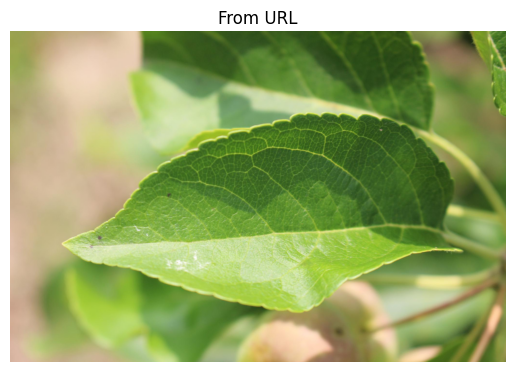

Predicted: healthy (95.96%)


In [20]:
url = "https://raw.githubusercontent.com/sakanaowo/PlantXViT/refs/heads/main/data/raw/plant-pathology-2020-fgvc7/images/Test_1101.jpg"
result = predict_image(url, model)
